In [2]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [15]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        
        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

## Prepare data

Initialize variables:

In [8]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

# testing busy vs relax

In [22]:
phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, ['7swyk'], seconds)
phase = StandardScaler().fit_transform(phase)
phase.shape

(6, 1290)

In [23]:
phase1 = phase[0::2]
phase0 = phase[1::2]

<Figure size 432x288 with 0 Axes>

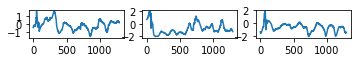

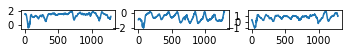

In [24]:
plot_n = 3
plt.figure(0)
plt.figure(figsize=(20, 6))
for i in range(plot_n):
    plt.subplot(10,10, i+1)
    plt.plot(phase0[i])
    
plt.figure(1)
plt.figure(figsize=(20, 4))
for i in range(plot_n):
    plt.subplot(10, 10, i+1)
    plt.plot(phase1[i])

In [34]:
train_idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
test_ident = ['7swyk']

phase_tr, y_tr, breathing_tr, heartbeat_tr, combined_tr = get_data_from_idents_br_hb(path, train_idents, seconds)
phase_tr = StandardScaler().fit_transform(phase_tr)

phase_te, y_te, breathing_te, heartbeat_te, combined_te = get_data_from_idents_br_hb(path, test_ident, seconds)
phase_te = StandardScaler().fit_transform(phase_te)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(phase_tr, y_tr.ravel())
curr_acc = np.sum(model.predict(phase_te) == y_te.ravel()) / len(y_te.ravel())
curr_acc

0.5

In [37]:
model.predict(phase_te)

array([1., 1., 1., 1., 1., 1.])

In [38]:
y_te

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [42]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(breathing_tr, y_tr.ravel())
curr_acc = np.sum(model.predict(breathing_te) == y_te.ravel()) / len(y_te.ravel())
curr_acc

0.8333333333333334

In [43]:
model.predict(breathing_te)

array([1., 0., 1., 1., 1., 0.])

In [44]:
y_te

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]])

#  testing low vs high

In [53]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue

        
        if cog_res['task_label'][task_num_table] != 'FA':
            continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [54]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [55]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [61]:
phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [idents[1]], seconds)
phase = StandardScaler().fit_transform(phase)
phase.shape

(20, 1290)

<Figure size 432x288 with 0 Axes>

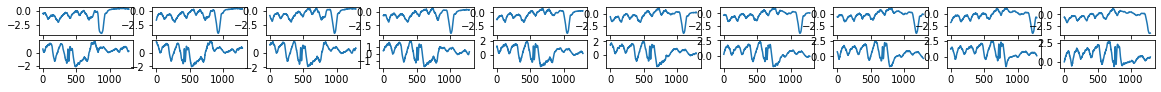

In [62]:
plot_n = 20
plt.figure(0)
plt.figure(figsize=(20, 6))
for i in range(plot_n):
    plt.subplot(10,10, i+1)
    plt.plot(phase[i])

In [63]:
y

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])